In [1]:
from matplotlib import pyplot as plt

import seaborn as sns
import glob,os,time,sys
from joblib import Parallel,delayed
import re
from collections import defaultdict
import fileinput
import HTSeq,pylab,pysam
import math
import pandas as pd
import numpy as np
import pickle

##Prepare R6 promoter with FC as output prediction to learn the activated copies
Repeat=pd.read_csv("mm10_rmsk_TE_location.bed",sep="\t",header=None)
Repeat["ID"]=Repeat[4].str.split(pat=".",expand=True)[0]
Repeat["length"]=Repeat[2]-Repeat[1]
RA=Repeat.loc[Repeat["ID"]=="RLTR6_Mm"]
RB=Repeat.loc[Repeat["ID"]=="RLTR6B_Mm"]
RC=Repeat.loc[Repeat["ID"]=="RLTR6C_Mm"]
RT=Repeat.loc[Repeat["ID"]=="RLTR6-int"]
ML30=Repeat.loc[Repeat["ID"]=="MMVL30-int"]
RABC=pd.concat([RA,RB,RC])
R_FL=pd.read_csv("ML30RT_FullLength.bed",sep="\t",header=None)
R_promoter=[[R_FL.iloc[i,3],R_FL.iloc[i,6]] if R_FL.iloc[i,5]=="+" else [R_FL.iloc[i,3],R_FL.iloc[i,7]] for i in range(R_FL.shape[0])]
R_promoter=[i for i in R_promoter if not re.search("int",i[1]) ]
Rpromoter=RABC[RABC[5].isin([i[1] for i in R_promoter])]

In [2]:
#load the big model 
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import selene_sdk
import torch
import sys
from torch import nn

import numpy as np
from torch import nn, einsum
import torch.nn.functional as F
import torch
from typing import Union
import math

In [3]:

class ConvBlock(nn.Module):
    def __init__(self, inp, oup, expand_ratio=2, fused=True):
        super(ConvBlock, self).__init__()
        hidden_dim = round(inp * expand_ratio)
        self.conv = nn.Sequential(
            nn.Conv1d(inp, hidden_dim, 9, 1, padding=4, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.SiLU(inplace=False),
            nn.Conv1d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm1d(oup),
        )


    def forward(self, x):
        return x + self.conv(x)


from torch import nn

class PuffinD(nn.Module):
    def __init__(self):
        """
        Parameters
        ----------
        """
        super(PuffinD, self).__init__()
        self.uplblocks = nn.ModuleList([
                nn.Sequential(
                nn.Conv1d(4, 64, kernel_size=17, padding=8),
            nn.BatchNorm1d(64)),

            nn.Sequential(
            nn.Conv1d(64, 96, stride=4, kernel_size=17, padding=8),
            nn.BatchNorm1d(96)),

            nn.Sequential(
                nn.Conv1d(96, 128, stride=4, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Conv1d(128, 128, stride=5, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Conv1d(128, 128, stride=5, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Conv1d(128, 128, stride=5, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Conv1d(128, 128, stride=2, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

        ])

        self.upblocks = nn.ModuleList([
            nn.Sequential(
            ConvBlock(64, 64, fused=True),
            ConvBlock(64, 64, fused=True)),

            nn.Sequential(
            ConvBlock(96, 96, fused=True),
            ConvBlock(96, 96, fused=True)),

            nn.Sequential(
                ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

        ])

        self.downlblocks = nn.ModuleList([
    
            nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(128, 128, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Upsample(scale_factor=5),
            nn.Conv1d(128, 128, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Upsample(scale_factor=5),
            nn.Conv1d(128, 128, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Upsample(scale_factor=5),
            nn.Conv1d(128, 128, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
                nn.Upsample(scale_factor=4),
            nn.Conv1d(128, 96, kernel_size=17, padding=8),
            nn.BatchNorm1d(96)),

            nn.Sequential(
            nn.Upsample(scale_factor=4),
            nn.Conv1d(96, 64, kernel_size=17, padding=8),
            nn.BatchNorm1d(64)),


        ])

        self.downblocks = nn.ModuleList([
                nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
                ConvBlock(96, 96, fused=True),
            ConvBlock(96, 96, fused=True)),

            nn.Sequential(
            ConvBlock(64, 64, fused=True),
            ConvBlock(64, 64, fused=True))


        ])

        self.uplblocks2 = nn.ModuleList([
    
            nn.Sequential(
            nn.Conv1d(64, 96, stride=4, kernel_size=17, padding=8),
            nn.BatchNorm1d(96)),

            nn.Sequential(
                nn.Conv1d(96, 128, stride=4, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Conv1d(128, 128, stride=5, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Conv1d(128, 128, stride=5, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Conv1d(128, 128, stride=5, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Conv1d(128, 128, stride=2, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

        ])

        self.upblocks2 = nn.ModuleList([
    
            nn.Sequential(
            ConvBlock(96, 96, fused=True),
            ConvBlock(96, 96, fused=True)),

            nn.Sequential(
                ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

        ])

        self.downlblocks2 = nn.ModuleList([
    
            nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(128, 128, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Upsample(scale_factor=5),
            nn.Conv1d(128, 128, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Upsample(scale_factor=5),
            nn.Conv1d(128, 128, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
            nn.Upsample(scale_factor=5),
            nn.Conv1d(128, 128, kernel_size=17, padding=8),
            nn.BatchNorm1d(128)),

            nn.Sequential(
                nn.Upsample(scale_factor=4),
            nn.Conv1d(128, 96, kernel_size=17, padding=8),
            nn.BatchNorm1d(96)),

            nn.Sequential(
            nn.Upsample(scale_factor=4),
            nn.Conv1d(96, 64, kernel_size=17, padding=8),
            nn.BatchNorm1d(64)),


        ])

        self.downblocks2 = nn.ModuleList([
                nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
            ConvBlock(128, 128, fused=True),
            ConvBlock(128, 128, fused=True)),

            nn.Sequential(
                ConvBlock(96, 96, fused=True),
            ConvBlock(96, 96, fused=True)),

            nn.Sequential(
            ConvBlock(64, 64, fused=True),
            ConvBlock(64, 64, fused=True))


        ])
        self.final =  nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 6, kernel_size=1),
            nn.Softplus())

    def forward(self, x):
        """Forward propagation of a batch.
        """
        out = x
        encodings = []
        for i, lconv, conv in zip(np.arange(len(self.uplblocks)), self.uplblocks, self.upblocks):
            lout = lconv(out)
            out = conv(lout)
            encodings.append(out)

        encodings2 = [out]
        for enc, lconv, conv in zip(reversed(encodings[:-1]), self.downlblocks, self.downblocks):
            lout = lconv(out)
            out = conv(lout)
            out = enc + out
            encodings2.append(out)

        encodings3 = [out]
        for enc, lconv, conv in zip(reversed(encodings2[:-1]), self.uplblocks2, self.upblocks2):
            lout = lconv(out)
            out = conv(lout)
            out = enc + out
            encodings3.append(out)

        for enc, lconv, conv in zip(reversed(encodings3[:-1]), self.downlblocks2, self.downblocks2):
            lout = lconv(out)
            out = conv(lout)
            out = enc + out

        out = self.final(out)
        return out
 

In [4]:
import pyBigWig
class GenomicSignalFeatures():
    """
    #Accept a list of cooler files as input.
    """
    def __init__(self, input_paths, features, shape, blacklists=None, blacklists_indices=None, 
        replacement_indices=None, replacement_scaling_factors=None):
        """
        Constructs a new `GenomicFeatures` object.
        """
        self.input_paths = input_paths
        self.initialized = False
        self.blacklists = blacklists
        self.blacklists_indices = blacklists_indices
        self.replacement_indices = replacement_indices
        self.replacement_scaling_factors = replacement_scaling_factors

            
        self.n_features = len(features)
        self.feature_index_dict = dict(
            [(feat, index) for index, feat in enumerate(features)])
        self.shape = (len(input_paths), *shape)

    def get_feature_data(self, chrom, start, end, nan_as_zero=True):
        if not self.initialized:
            self.data = [pyBigWig.open(path) for path in self.input_paths]
            if self.blacklists is not None:
                self.blacklists = [tabix.open(blacklist)  for blacklist in self.blacklists]
            self.initialized=True
            
        wigmat = np.vstack([c.values(chrom, start, end, numpy=True)
                           for c in self.data])
        
        if self.blacklists is not None:
            if self.replacement_indices is None:
                for blacklist, blacklist_indices in zip(self.blacklists, self.blacklists_indices):
                    for _, s, e in blacklist.query(chrom, start, end):
                        wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = 0
            else:
                for blacklist, blacklist_indices, replacement_indices, replacement_scaling_factor in zip(self.blacklists, self.blacklists_indices, self.replacement_indices, self.replacement_scaling_factors):
                        for _, s, e in blacklist.query(chrom, start, end):
                            wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = wigmat[replacement_indices, np.fmax(int(s)-start,0): int(e)-start] * replacement_scaling_factor

        if nan_as_zero:
            wigmat[np.isnan(wigmat)]=0
        return wigmat


tfeature = GenomicSignalFeatures(
    [
        "ATAC-P1_S7_R2_001Aligned.sortedByCoord.out.bw",
        "ATAC-P2_S8_R2_001Aligned.sortedByCoord.out.bw",
        "ATAC-P3_S9_R2_001Aligned.sortedByCoord.out.bw",
        "ATAC-S1_S10_R2_001Aligned.sortedByCoord.out.bw",
        "ATAC-S2_S11_R2_001Aligned.sortedByCoord.out.bw",
        "ATAC-S3_S12_R2_001Aligned.sortedByCoord.out.bw",

    ],
    ["ATAC-P1", "ATAC-P2","ATAC-P3","ATAC-S1","ATAC-S2","ATAC-S3"],
    (100000,),
)






In [6]:
bignet = torch.load('SenNet_ATAC.pth')
state_dict = bignet.state_dict()
bignet = nn.DataParallel(PuffinD())
bignet.load_state_dict(state_dict)
bignet.eval()

DataParallel(
  (module): PuffinD(
    (uplblocks): ModuleList(
      (0): Sequential(
        (0): Conv1d(4, 64, kernel_size=(17,), stride=(1,), padding=(8,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv1d(64, 96, kernel_size=(17,), stride=(4,), padding=(8,))
        (1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): Conv1d(96, 128, kernel_size=(17,), stride=(4,), padding=(8,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): Sequential(
        (0): Conv1d(128, 128, kernel_size=(17,), stride=(5,), padding=(8,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (4): Sequential(
        (0): Conv1d(128, 128, kernel_size=(17,), stride=(5,), padding=(8,))
        (1): BatchNorm1d(128, eps=1e-05, 

In [7]:
genome = selene_sdk.sequences.Genome(input_path='mm10.fa')

In [67]:
#evaluate chromosome-wide performance for bignet
# import numpy as np
allseq = genome.get_encoding_from_coords('chr8',0, 129401213)
allcage = tfeature.get_feature_data('chr8',0, 129401213)
bignet.eval()
with torch.no_grad():
    allpred = np.zeros((6,129401213))
    for i in np.arange(0, 129401213, 50000)[:-2]:
        pred = bignet(torch.FloatTensor(allseq[i:i+100000,:][None,:,:]).transpose(1,2).cuda()).cpu().detach().numpy()
        allpred[:,i+25000:i+75000] = pred[0,:,25000:75000]
    i = 129401213-100000
    pred = bignet(torch.FloatTensor(allseq[i:i+100000,:][None,:,:]).transpose(1,2).cuda()).cpu().detach().numpy()
    allpred[:,i+25000:i+75000] = pred[0,:,25000:75000]
allpred = allpred[:,25000:-25000]
allcage = allcage[:,25000:-25000]
allseq = allseq[25000:-25000,:]



In [68]:
#evaluate chromosome-wide performance for bignet
import numpy as np
allseq2 = genome.get_encoding_from_coords('chr9',0, 124595110)
allcage2 = tfeature.get_feature_data('chr9',0, 124595110)
bignet.eval()
with torch.no_grad():
    allpred2 = np.zeros((6,124595110))
    for i in np.arange(0, 124595110, 50000)[:-2]:
        pred = bignet(torch.FloatTensor(allseq2[i:i+100000,:][None,:,:]).transpose(1,2).cuda()).cpu().detach().numpy()
        allpred2[:,i+25000:i+75000] = pred[0,:,25000:75000]
    i = 124595110-100000
    pred = bignet(torch.FloatTensor(allseq2[i:i+100000,:][None,:,:]).transpose(1,2).cuda()).cpu().detach().numpy()
    allpred2[:,i+25000:i+75000] = pred[0,:,25000:75000]
allpred2 = allpred2[:,25000:-25000]
allcage2 = allcage2[:,25000:-25000]
allseq2 = allseq2[25000:-25000,:]


In [69]:
import numpy as np
allseq3 = genome.get_encoding_from_coords('chr10',0, 130694993)
allcage3 = tfeature.get_feature_data('chr10',0, 130694993)
bignet.eval()
with torch.no_grad():
    allpred3 = np.zeros((6,130694993))
    for i in np.arange(0, 130694993, 50000)[:-2]:
        pred = bignet(torch.FloatTensor(allseq3[i:i+100000,:][None,:,:]).transpose(1,2).cuda()).cpu().detach().numpy()
        allpred3[:,i+25000:i+75000] = pred[0,:,25000:75000]
    i = 130694993-100000
    pred = bignet(torch.FloatTensor(allseq3[i:i+100000,:][None,:,:]).transpose(1,2).cuda()).cpu().detach().numpy()
    allpred3[:,i+25000:i+75000] = pred[0,:,25000:75000]
allpred3 = allpred3[:,25000:-25000]
allcage3 = allcage3[:,25000:-25000]
allseq3 = allseq3[25000:-25000,:]

In [70]:
allseq_n = (allseq == 0.25).all(axis=-1)
from scipy.signal import convolve
allseq_n_1k = convolve(allseq_n, np.ones(1001), mode='same')
valid_seqlocs = allseq_n_1k<0.1
allpred[:,~valid_seqlocs]=0
allcage[:,~valid_seqlocs]=0

In [71]:
allseq_n = (allseq2 == 0.25).all(axis=-1)
from scipy.signal import convolve
allseq_n_1k = convolve(allseq_n, np.ones(1001), mode='same')
valid_seqlocs2 = allseq_n_1k<0.1
allpred2[:,~valid_seqlocs2]=0
allcage2[:,~valid_seqlocs2]=0

In [72]:
allseq_n = (allseq3 == 0.25).all(axis=-1)
from scipy.signal import convolve
allseq_n_1k = convolve(allseq_n, np.ones(1001), mode='same')
valid_seqlocs3 = allseq_n_1k<0.1
allpred3[:,~valid_seqlocs3]=0
allcage3[:,~valid_seqlocs3]=0

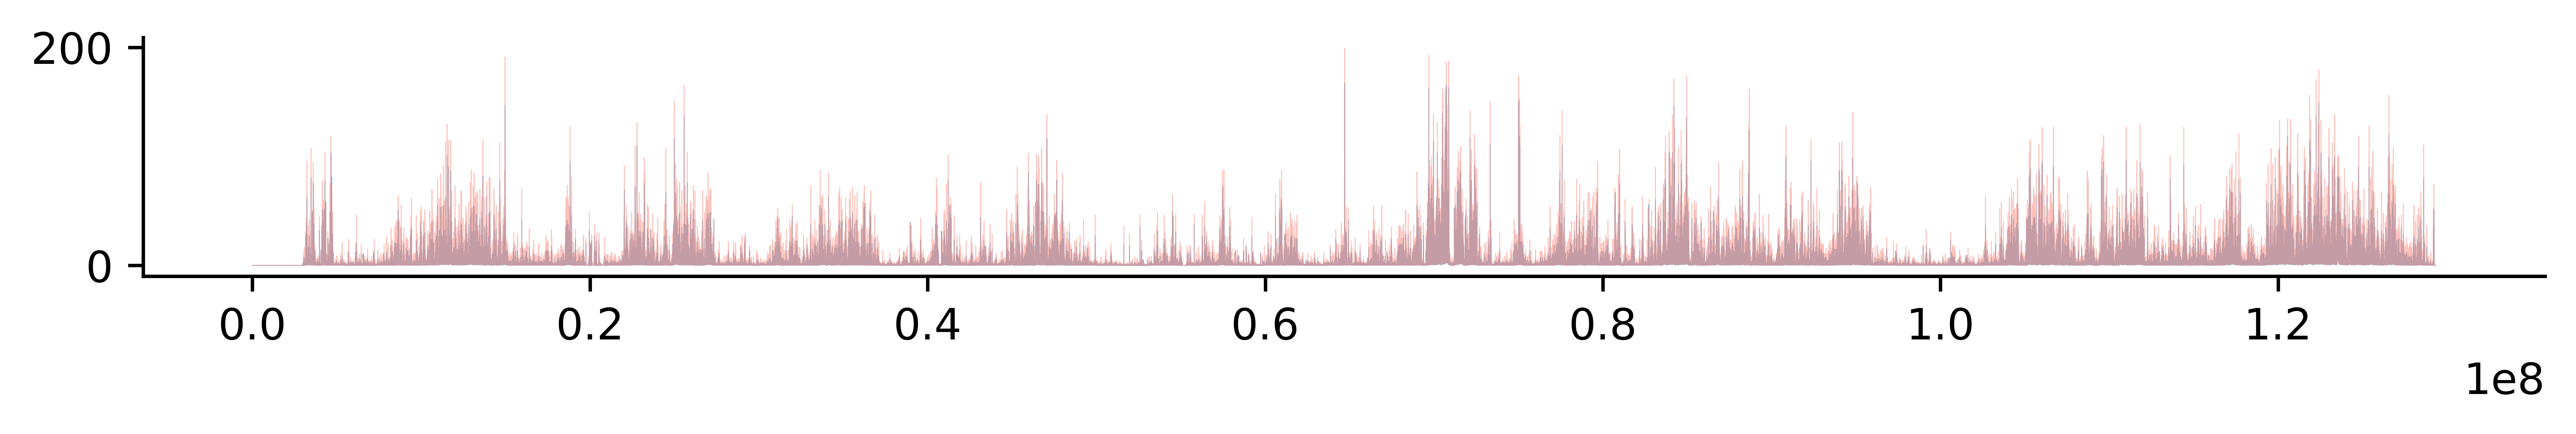

In [79]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,1),dpi=1000)
plt.plot(allpred[:3,:].mean(0), linewidth=0.2, color='#2077b4',alpha=0.5, rasterized=True)
plt.plot(allpred[3:,:].mean(0), linewidth=0.2, color='#FA8072',alpha=0.5, rasterized=True)
sns.despine()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("SenNet_ATAC_chr8_pred.pdf")

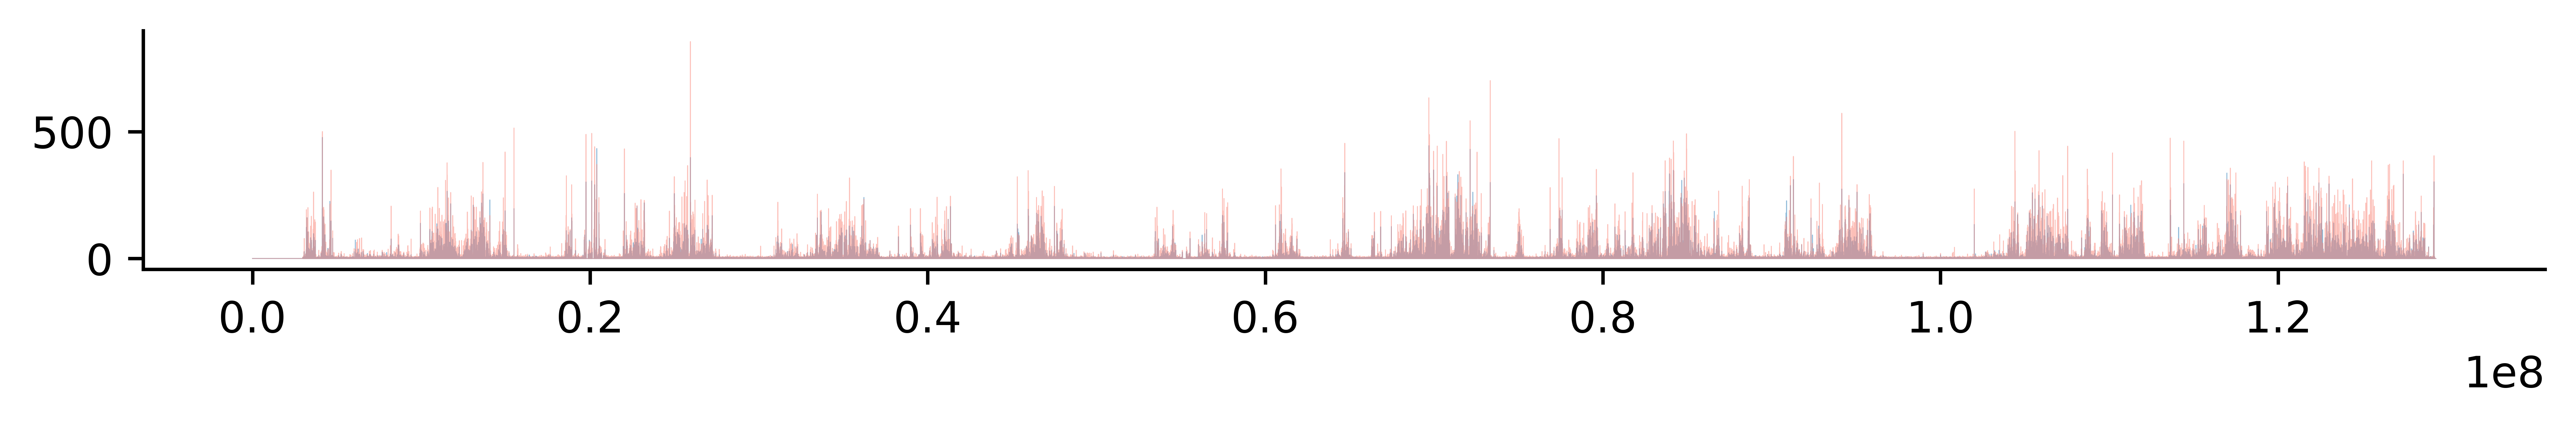

In [80]:
%matplotlib inline
plt.figure(figsize=(10,1),dpi=1000)
plt.plot(allcage[:3,:].mean(0), linewidth=0.2, color='#2077b4',alpha=0.5, rasterized=True)
plt.plot(allcage[3:,:].mean(0), linewidth=0.2, color='#FA8072',alpha=0.5, rasterized=True)
sns.despine()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("SenNet_ATAC_chr8_exp.pdf")

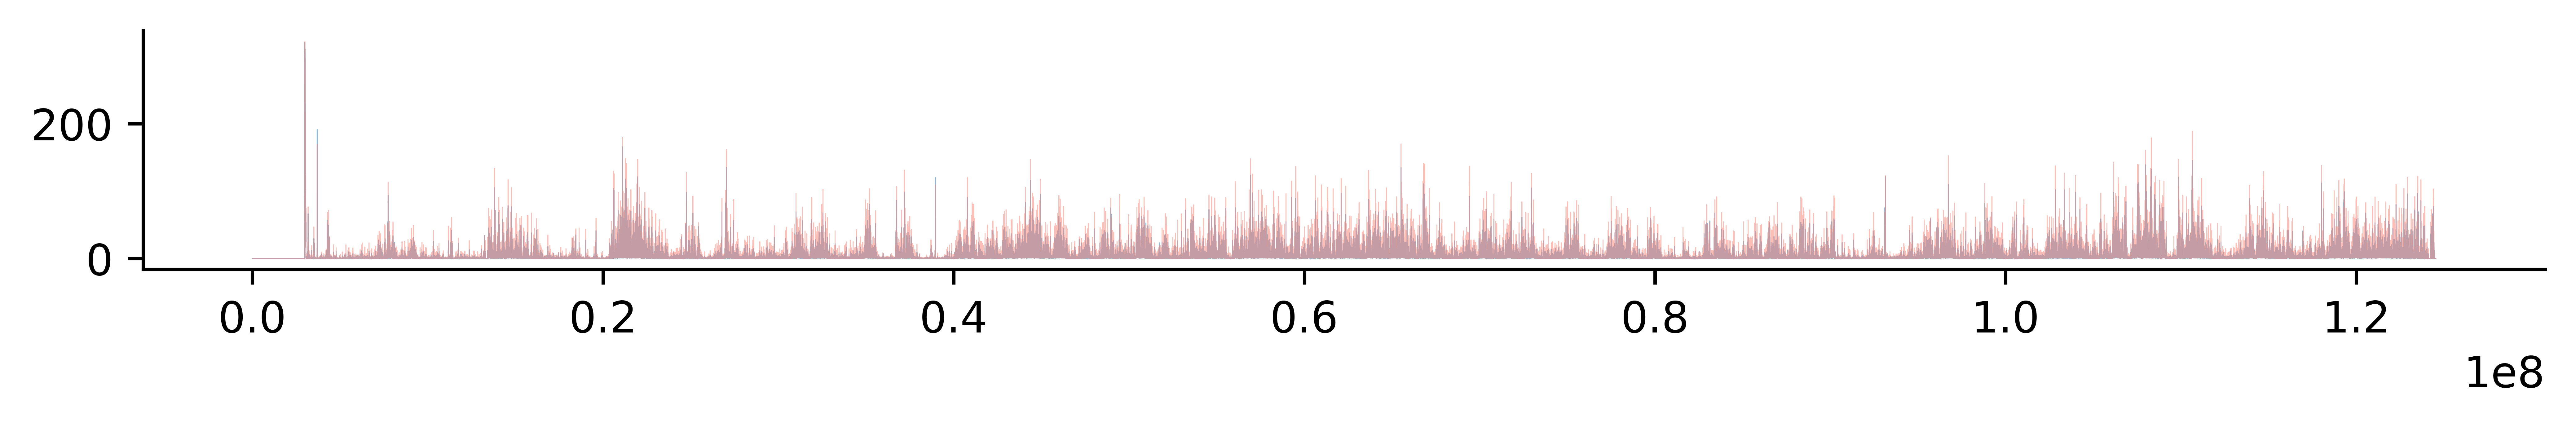

In [81]:
plt.figure(figsize=(10,1),dpi=1000)
plt.plot(allpred2[:3,:].mean(0), linewidth=0.2, color='#2077b4',alpha=0.5, rasterized=True)
plt.plot(allpred2[3:,:].mean(0), linewidth=0.2, color='#FA8072',alpha=0.5, rasterized=True)
sns.despine()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("SenNet_ATAC_chr9_pred.pdf")

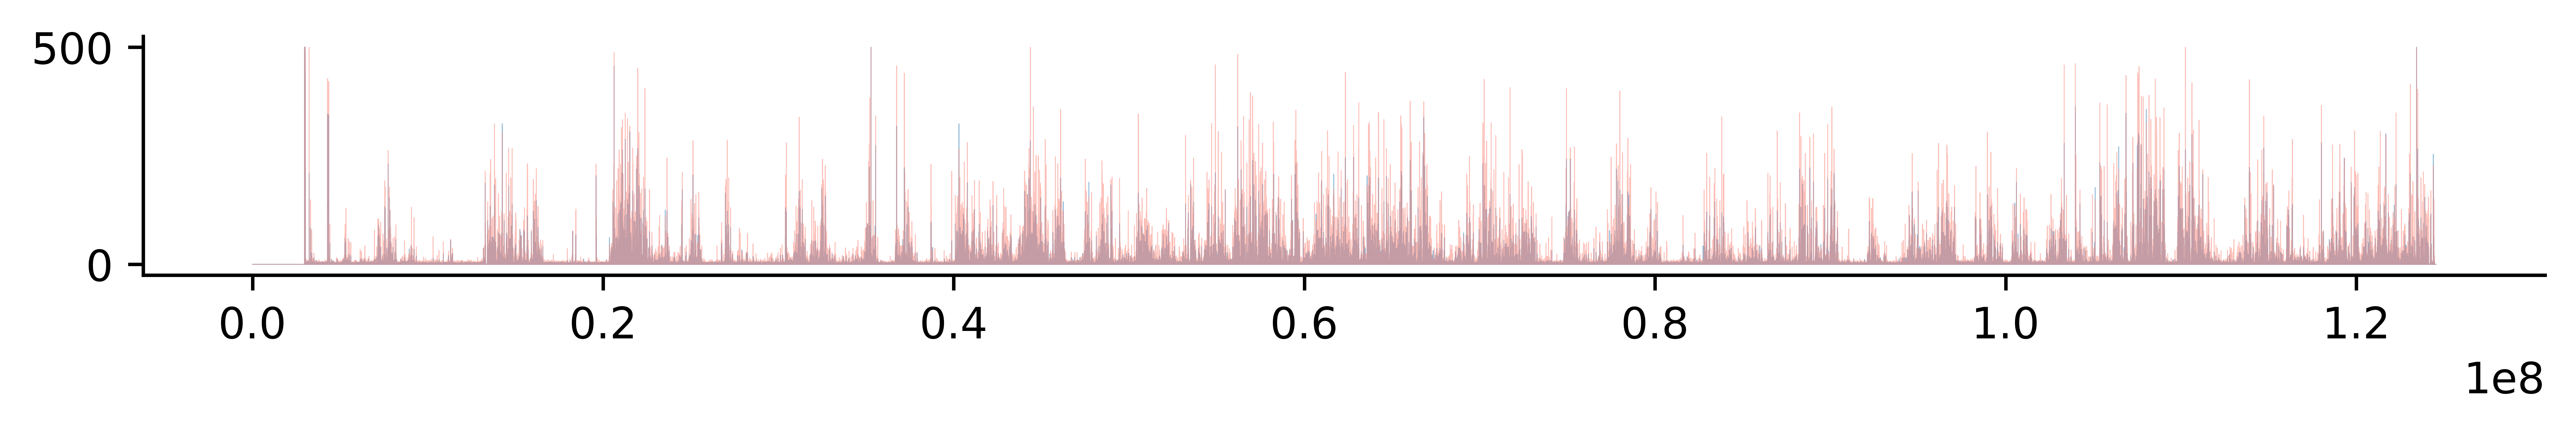

In [82]:
allcage2[allcage2>500]=500
%matplotlib inline
plt.figure(figsize=(10,1),dpi=1000)
plt.plot(allcage2[:3,:].mean(0), linewidth=0.2, color='#2077b4',alpha=0.5, rasterized=True)
plt.plot(allcage2[3:,:].mean(0), linewidth=0.2, color='#FA8072',alpha=0.5, rasterized=True)
sns.despine()
plt.savefig("SenNet_ATAC_chr9_exp.pdf")

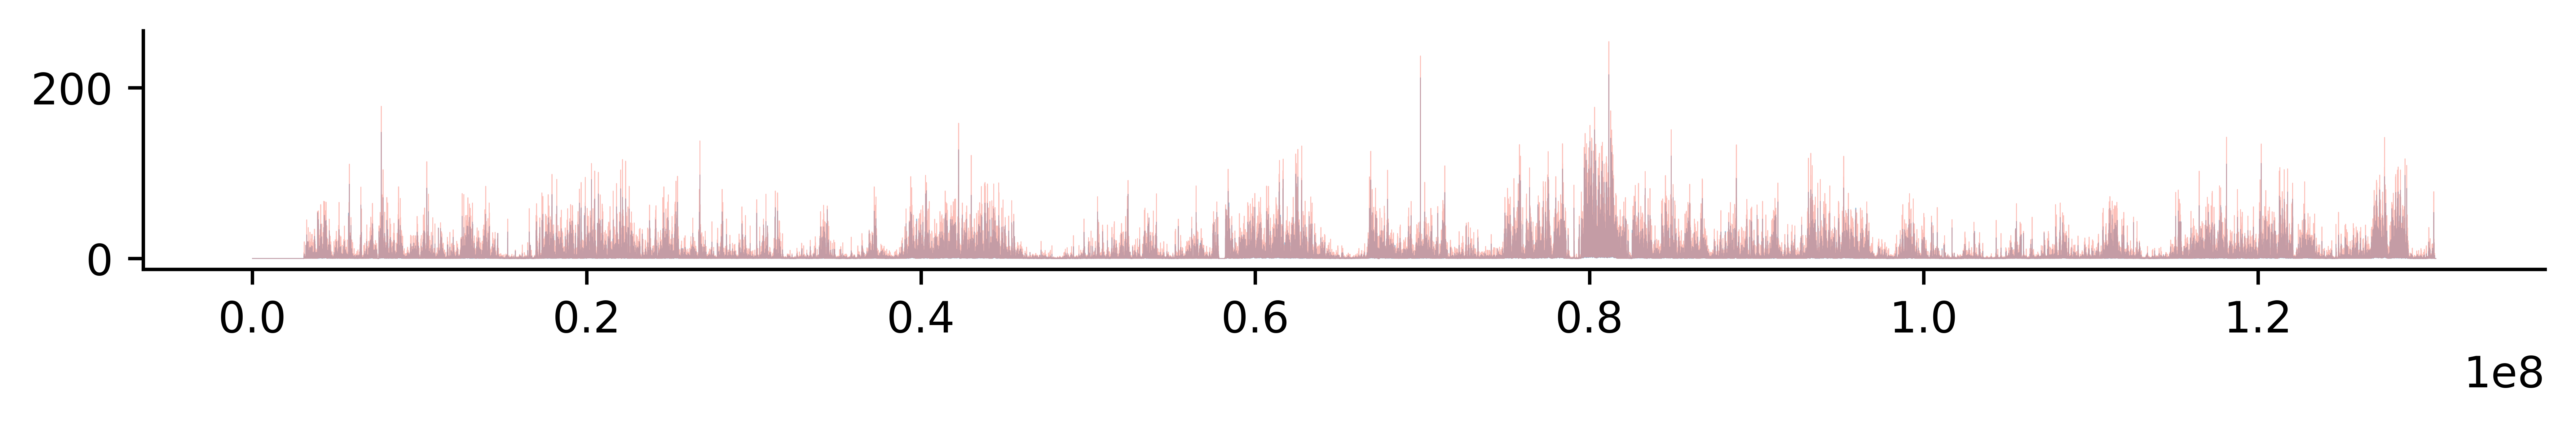

In [83]:
plt.figure(figsize=(10,1),dpi=1000)
plt.plot(allpred3[:3,:].mean(0), linewidth=0.2, color='#2077b4',alpha=0.5, rasterized=True)
plt.plot(allpred3[3:,:].mean(0), linewidth=0.2, color='#FA8072',alpha=0.5, rasterized=True)
sns.despine()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("SenNet_ATAC_chr10_pred.pdf")

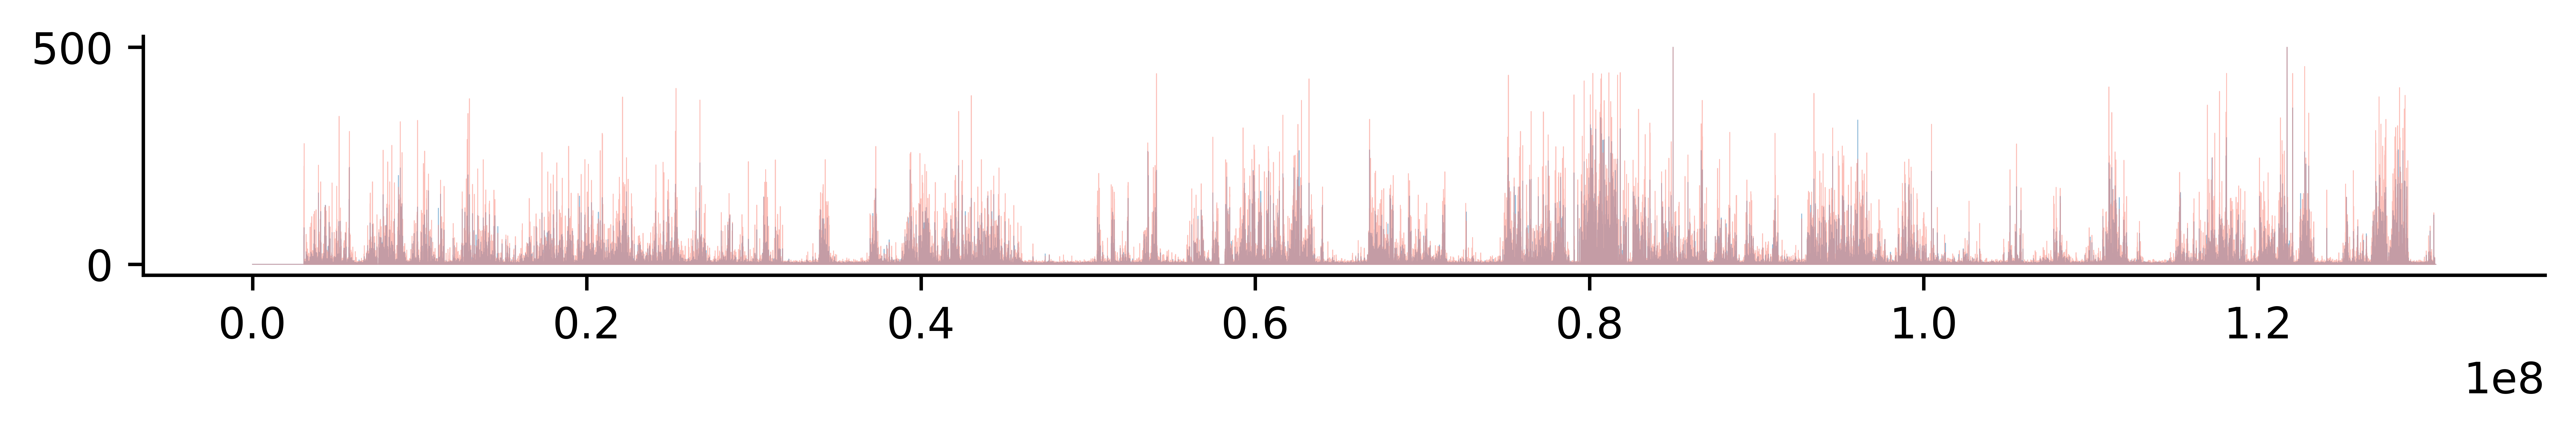

In [84]:
allcage3[allcage3>500]=500
%matplotlib inline
plt.figure(figsize=(10,1),dpi=1000)
plt.plot(allcage3[:3,:].mean(0), linewidth=0.2, color='#2077b4',alpha=0.5, rasterized=True)
plt.plot(allcage3[3:,:].mean(0), linewidth=0.2, color='#FA8072',alpha=0.5, rasterized=True)
sns.despine()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("SenNet_ATAC_chr10_exp.pdf")

In [38]:
import pandas as pd
tssanno = pd.read_csv('gencode.vM25.annotation.gtf', sep="\t",header=None)
tssanno=tssanno[(tssanno[2]=="transcript") & (tssanno[0].isin(["chr8","chr9","chr10"]))]
tssanno[3]=tssanno[3]-25000
tssanno[4]=tssanno[4]-25000

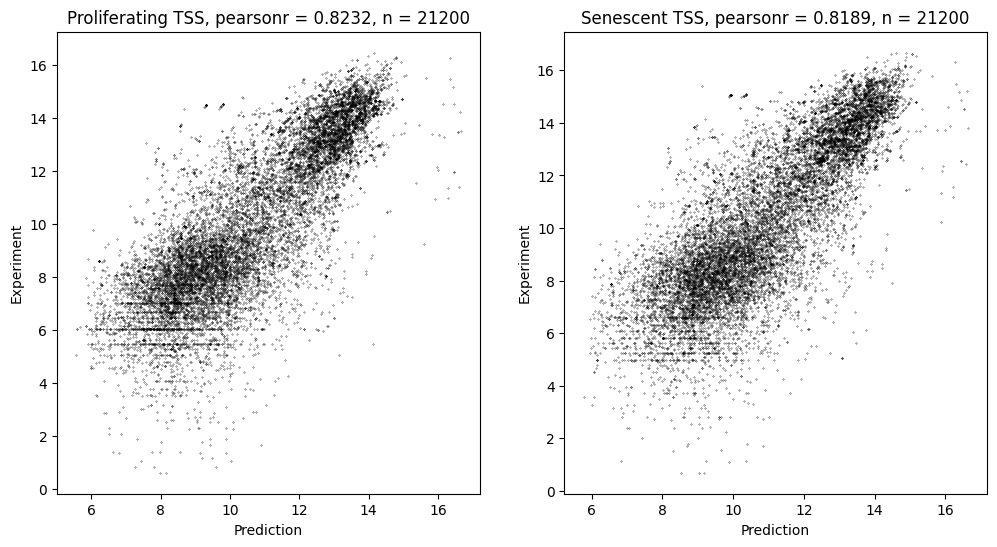

In [58]:
from scipy.stats import pearsonr
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2,6*1))

#P
windowsize=400
tssanno_1=tssanno[(tssanno[0]=="chr8") & (tssanno[6]=="+")]
tssanno_2=tssanno[(tssanno[0]=="chr8") & (tssanno[6]=="-")]
allpred_TSS=[np.log2((allpred[:3,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1) for i in range(tssanno_1.shape[0])]+\
            [np.log2((allpred[:3,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1)  for i in range(tssanno_2.shape[0])]
allcage_TSS=[np.log2((allcage[:3,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1)  for i in range(tssanno_1.shape[0])]+\
            [np.log2((allcage[:3,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1)  for i in range(tssanno_2.shape[0])]
windowsize=400
tssanno_1=tssanno[(tssanno[0]=="chr9") & (tssanno[6]=="+")]
tssanno_2=tssanno[(tssanno[0]=="chr9") & (tssanno[6]=="-")]
allpred2_TSS=[np.log2((allpred2[:3,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1) for i in range(tssanno_1.shape[0])]+\
            [np.log2((allpred2[:3,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1) for i in range(tssanno_2.shape[0])]
allcage2_TSS=[np.log2((allcage2[:3,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1) for i in range(tssanno_1.shape[0])]+\
            [np.log2((allcage2[:3,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1) for i in range(tssanno_2.shape[0])]
windowsize=400
tssanno_1=tssanno[(tssanno[0]=="chr10") & (tssanno[6]=="+")]
tssanno_2=tssanno[(tssanno[0]=="chr10") & (tssanno[6]=="-")]
allpred3_TSS=[np.log2((allpred3[:3,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1) for i in range(tssanno_1.shape[0])]+\
            [np.log2((allpred3[:3,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1) for i in range(tssanno_2.shape[0])]
allcage3_TSS=[np.log2((allcage3[:3,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1) for i in range(tssanno_1.shape[0])]+\
            [np.log2((allcage3[:3,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1) for i in range(tssanno_2.shape[0])]

plt.style.use('default')
pred=np.array(allpred_TSS+allpred2_TSS+allpred3_TSS)
exp=np.array(allcage_TSS+allcage2_TSS+allcage3_TSS)
pred=pred[exp>0]
exp=exp[exp>0]
axes[0].plot(pred,exp,'.', markersize=0.5, c='black', rasterized=True)
cor = pearsonr(pred, 
             exp)[0]
axes[0].title.set_text('Proliferating TSS, pearsonr = ' + "{:.4f}".format(cor)+", n = "+ "{:.0f}".format(len(allpred_TSS+allpred2_TSS+allpred3_TSS)))
axes[0].set_xlabel('Prediction')
axes[0].set_ylabel('Experiment')


#S
windowsize=400
tssanno_1=tssanno[(tssanno[0]=="chr8") & (tssanno[6]=="+")]
tssanno_2=tssanno[(tssanno[0]=="chr8") & (tssanno[6]=="-")]
allpred_TSS=[np.log2((allpred[3:,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1) for i in range(tssanno_1.shape[0])]+\
            [np.log2((allpred[3:,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1)  for i in range(tssanno_2.shape[0])]
allcage_TSS=[np.log2((allcage[3:,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1)  for i in range(tssanno_1.shape[0])]+\
            [np.log2((allcage[3:,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1)  for i in range(tssanno_2.shape[0])]
windowsize=400
tssanno_1=tssanno[(tssanno[0]=="chr9") & (tssanno[6]=="+")]
tssanno_2=tssanno[(tssanno[0]=="chr9") & (tssanno[6]=="-")]
allpred2_TSS=[np.log2((allpred2[3:,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1) for i in range(tssanno_1.shape[0])]+\
            [np.log2((allpred2[3:,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1) for i in range(tssanno_2.shape[0])]
allcage2_TSS=[np.log2((allcage2[3:,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1) for i in range(tssanno_1.shape[0])]+\
            [np.log2((allcage2[3:,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1) for i in range(tssanno_2.shape[0])]
windowsize=400
tssanno_1=tssanno[(tssanno[0]=="chr10") & (tssanno[6]=="+")]
tssanno_2=tssanno[(tssanno[0]=="chr10") & (tssanno[6]=="-")]
allpred3_TSS=[np.log2((allpred3[3:,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1) for i in range(tssanno_1.shape[0])]+\
            [np.log2((allpred3[3:,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1) for i in range(tssanno_2.shape[0])]
allcage3_TSS=[np.log2((allcage3[3:,tssanno_1.iloc[i][3]-200:tssanno_1.iloc[i][3]+200].mean(0)).sum()+1) for i in range(tssanno_1.shape[0])]+\
            [np.log2((allcage3[3:,tssanno_2.iloc[i][4]-200:tssanno_2.iloc[i][4]+200].mean(0)).sum()+1) for i in range(tssanno_2.shape[0])]

pred=np.array(allpred_TSS+allpred2_TSS+allpred3_TSS)
exp=np.array(allcage_TSS+allcage2_TSS+allcage3_TSS)
pred=pred[exp>0]
exp=exp[exp>0]
axes[1].plot(pred,exp,'.', markersize=0.5, c='black', rasterized=True)
cor = pearsonr(pred, 
             exp)[0]
axes[1].title.set_text('Senescent TSS, pearsonr = ' + "{:.4f}".format(cor)+", n = "+ "{:.0f}".format(len(allpred_TSS+allpred2_TSS+allpred3_TSS)))
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Experiment')



plt.rcParams['pdf.fonttype'] = 42

plt.savefig("SenNet_ATAC_TSS.pdf")

In [55]:
pred=np.array(allpred_TSS+allpred2_TSS+allpred3_TSS)
exp=np.array(allcage_TSS+allcage2_TSS+allcage3_TSS)
pred=pred[exp>0]
exp=exp[exp>0]

axes[1].plot(pred,exp,'.', markersize=0.5, c='black', rasterized=True)
cor = pearsonr(pred, 
             exp)[0]
axes[1].title.set_text('Senescent TSS, pearsonr = ' + "{:.4f}".format(cor)+", n = "+ "{:.0f}".format(len(allpred_TSS+allpred2_TSS+allpred3_TSS)))
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Experiment')

Text(2105.5397727272725, 0.5, 'Experiment')

In [56]:
cor

0.818896989797466

In [60]:
transcriptanno = pd.read_csv('gencode.vM25.annotation.gtf', sep="\t",header=None)
transcriptanno=transcriptanno[(transcriptanno[2]=="transcript") & (transcriptanno[0].isin(["chr8","chr9","chr10"]))]
transcriptanno[3]=transcriptanno[3]-25000
transcriptanno[4]=transcriptanno[4]-25000
transcriptanno

,0,1,2,3,4,5,6,7,8
840673,chr8,HAVANA,transcript,3031294,3031445,.,+,.,"gene_id ""ENSMUSG00000108612.2""; transcript_id ..."
840676,chr8,HAVANA,transcript,3068369,3070187,.,+,.,"gene_id ""ENSMUSG00000090795.1""; transcript_id ..."
840681,chr8,ENSEMBL,transcript,3074386,3074506,.,-,.,"gene_id ""ENSMUSG00000080366.1""; transcript_id ..."
840684,chr8,HAVANA,transcript,3079279,3080802,.,+,.,"gene_id ""ENSMUSG00000108971.1""; transcript_id ..."
840687,chr8,HAVANA,transcript,3097061,3134555,.,-,.,"gene_id ""ENSMUSG00000005534.10""; transcript_id..."
...,...,...,...,...,...,...,...,...,...
1124357,chr10,HAVANA,transcript,130510562,130510961,.,-,.,"gene_id ""ENSMUSG00000112195.1""; transcript_id ..."
1124360,chr10,HAVANA,transcript,130517347,130546793,.,+,.,"gene_id ""ENSMUSG00000112742.1""; transcript_id ..."
1124365,chr10,ENSEMBL,transcript,130532348,130532464,.,-,.,"gene_id ""ENSMUSG00000096766.1""; transcript_id ..."
1124368,chr10,ENSEMBL,transcript,130567136,130567244,.,-,.,"gene_id ""ENSMUSG00000093816.1""; transcript_id ..."


In [61]:
transcriptanno_1=transcriptanno[(transcriptanno[0]=="chr8") & (transcriptanno[6]=="+")]
transcriptanno_2=transcriptanno[(transcriptanno[0]=="chr8") & (transcriptanno[6]=="-")]
allpred_transcript=[np.log2((allpred[0,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]]-1).sum()+0.05) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allpred[0,transcriptanno_2.iloc[i][4]-200:transcriptanno_2.iloc[i][4]+200]-1).sum()+0.05)  for i in range(transcriptanno_2.shape[0])]
allcage_transcript=[np.log2((allcage[0,transcriptanno_1.iloc[i][3]-200:transcriptanno_1.iloc[i][3]+200]-1).sum()+0.05)  for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allcage[0,transcriptanno_2.iloc[i][4]-200:transcriptanno_2.iloc[i][4]+200]-1).sum()+0.05)  for i in range(transcriptanno_2.shape[0])]


/tmp/ipykernel_8652/2427242887.py:3: RuntimeWarning: invalid value encountered in log2
  allpred_transcript=[np.log2((allpred[0,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]]-1).sum()+0.05) for i in range(transcriptanno_1.shape[0])]+\
/tmp/ipykernel_8652/2427242887.py:4: RuntimeWarning: invalid value encountered in log2
  [np.log2((allpred[0,transcriptanno_2.iloc[i][4]-200:transcriptanno_2.iloc[i][4]+200]-1).sum()+0.05)  for i in range(transcriptanno_2.shape[0])]


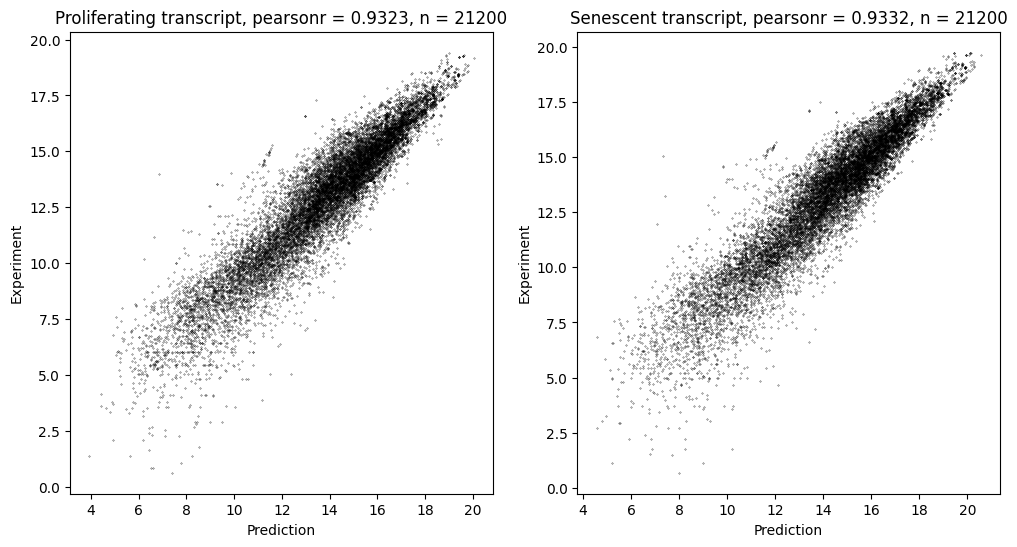

In [62]:
##Whole transcript

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2,6*1))

#P

transcriptanno_1=transcriptanno[(transcriptanno[0]=="chr8") & (transcriptanno[6]=="+")]
transcriptanno_2=transcriptanno[(transcriptanno[0]=="chr8") & (transcriptanno[6]=="-")]
allpred_transcript=[np.log2((allpred[:3,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allpred[:3,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1)  for i in range(transcriptanno_2.shape[0])]
allcage_transcript=[np.log2((allcage[:3,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1)  for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allcage[:3,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1)  for i in range(transcriptanno_2.shape[0])]

transcriptanno_1=transcriptanno[(transcriptanno[0]=="chr9") & (transcriptanno[6]=="+")]
transcriptanno_2=transcriptanno[(transcriptanno[0]=="chr9") & (transcriptanno[6]=="-")]
allpred2_transcript=[np.log2((allpred2[:3,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allpred2[:3,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_2.shape[0])]
allcage2_transcript=[np.log2((allcage2[:3,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allcage2[:3,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_2.shape[0])]

transcriptanno_1=transcriptanno[(transcriptanno[0]=="chr10") & (transcriptanno[6]=="+")]
transcriptanno_2=transcriptanno[(transcriptanno[0]=="chr10") & (transcriptanno[6]=="-")]
allpred3_transcript=[np.log2((allpred3[:3,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allpred3[:3,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_2.shape[0])]
allcage3_transcript=[np.log2((allcage3[:3,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allcage3[:3,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_2.shape[0])]



plt.style.use('default')
pred=np.array(allpred_transcript+allpred2_transcript+allpred3_transcript)
exp=np.array(allcage_transcript+allcage2_transcript+allcage3_transcript)
pred=pred[exp>0]
exp=exp[exp>0]
axes[0].plot(pred,exp,'.', markersize=0.5, c='black', rasterized=True)
cor = pearsonr(pred, 
             exp)[0]
axes[0].title.set_text('Proliferating transcript, pearsonr = ' + "{:.4f}".format(cor)+", n = "+ "{:.0f}".format(len(allpred_transcript+allpred2_transcript+allpred3_transcript)))
axes[0].set_xlabel('Prediction')
axes[0].set_ylabel('Experiment')


#S

transcriptanno_1=transcriptanno[(transcriptanno[0]=="chr8") & (transcriptanno[6]=="+")]
transcriptanno_2=transcriptanno[(transcriptanno[0]=="chr8") & (transcriptanno[6]=="-")]
allpred_transcript=[np.log2((allpred[3:,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allpred[3:,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1)  for i in range(transcriptanno_2.shape[0])]
allcage_transcript=[np.log2((allcage[3:,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1)  for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allcage[3:,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1)  for i in range(transcriptanno_2.shape[0])]

transcriptanno_1=transcriptanno[(transcriptanno[0]=="chr9") & (transcriptanno[6]=="+")]
transcriptanno_2=transcriptanno[(transcriptanno[0]=="chr9") & (transcriptanno[6]=="-")]
allpred2_transcript=[np.log2((allpred2[3:,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allpred2[3:,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_2.shape[0])]
allcage2_transcript=[np.log2((allcage2[3:,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allcage2[3:,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_2.shape[0])]

transcriptanno_1=transcriptanno[(transcriptanno[0]=="chr10") & (transcriptanno[6]=="+")]
transcriptanno_2=transcriptanno[(transcriptanno[0]=="chr10") & (transcriptanno[6]=="-")]
allpred3_transcript=[np.log2((allpred3[3:,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allpred3[3:,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_2.shape[0])]
allcage3_transcript=[np.log2((allcage3[3:,transcriptanno_1.iloc[i][3]:transcriptanno_1.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_1.shape[0])]+\
            [np.log2((allcage3[3:,transcriptanno_2.iloc[i][3]:transcriptanno_2.iloc[i][4]].mean(0)).sum()+1) for i in range(transcriptanno_2.shape[0])]



pred=np.array(allpred_transcript+allpred2_transcript+allpred3_transcript)
exp=np.array(allcage_transcript+allcage2_transcript+allcage3_transcript)
pred=pred[exp>0]
exp=exp[exp>0]
axes[1].plot(pred,exp,'.', markersize=0.5, c='black', rasterized=True)
cor = pearsonr(pred, 
             exp)[0]


axes[1].title.set_text('Senescent transcript, pearsonr = ' + "{:.4f}".format(cor)+", n = "+ "{:.0f}".format(len(allpred_transcript+allpred2_transcript+allpred3_transcript)))
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Experiment')



plt.rcParams['pdf.fonttype'] = 42
plt.savefig("SenNet_ATAC_transcript.pdf")

In [26]:
## example
allseq = genome.get_encoding_from_coords('chr1',174031932-50000, 174031932+50000)

allcage = tfeature.get_feature_data('chr1',174031932-50000, 174031932+50000)

pred = bignet(torch.FloatTensor(allseq[None,:,:]).transpose(1,2).cuda()).cpu().detach().numpy()

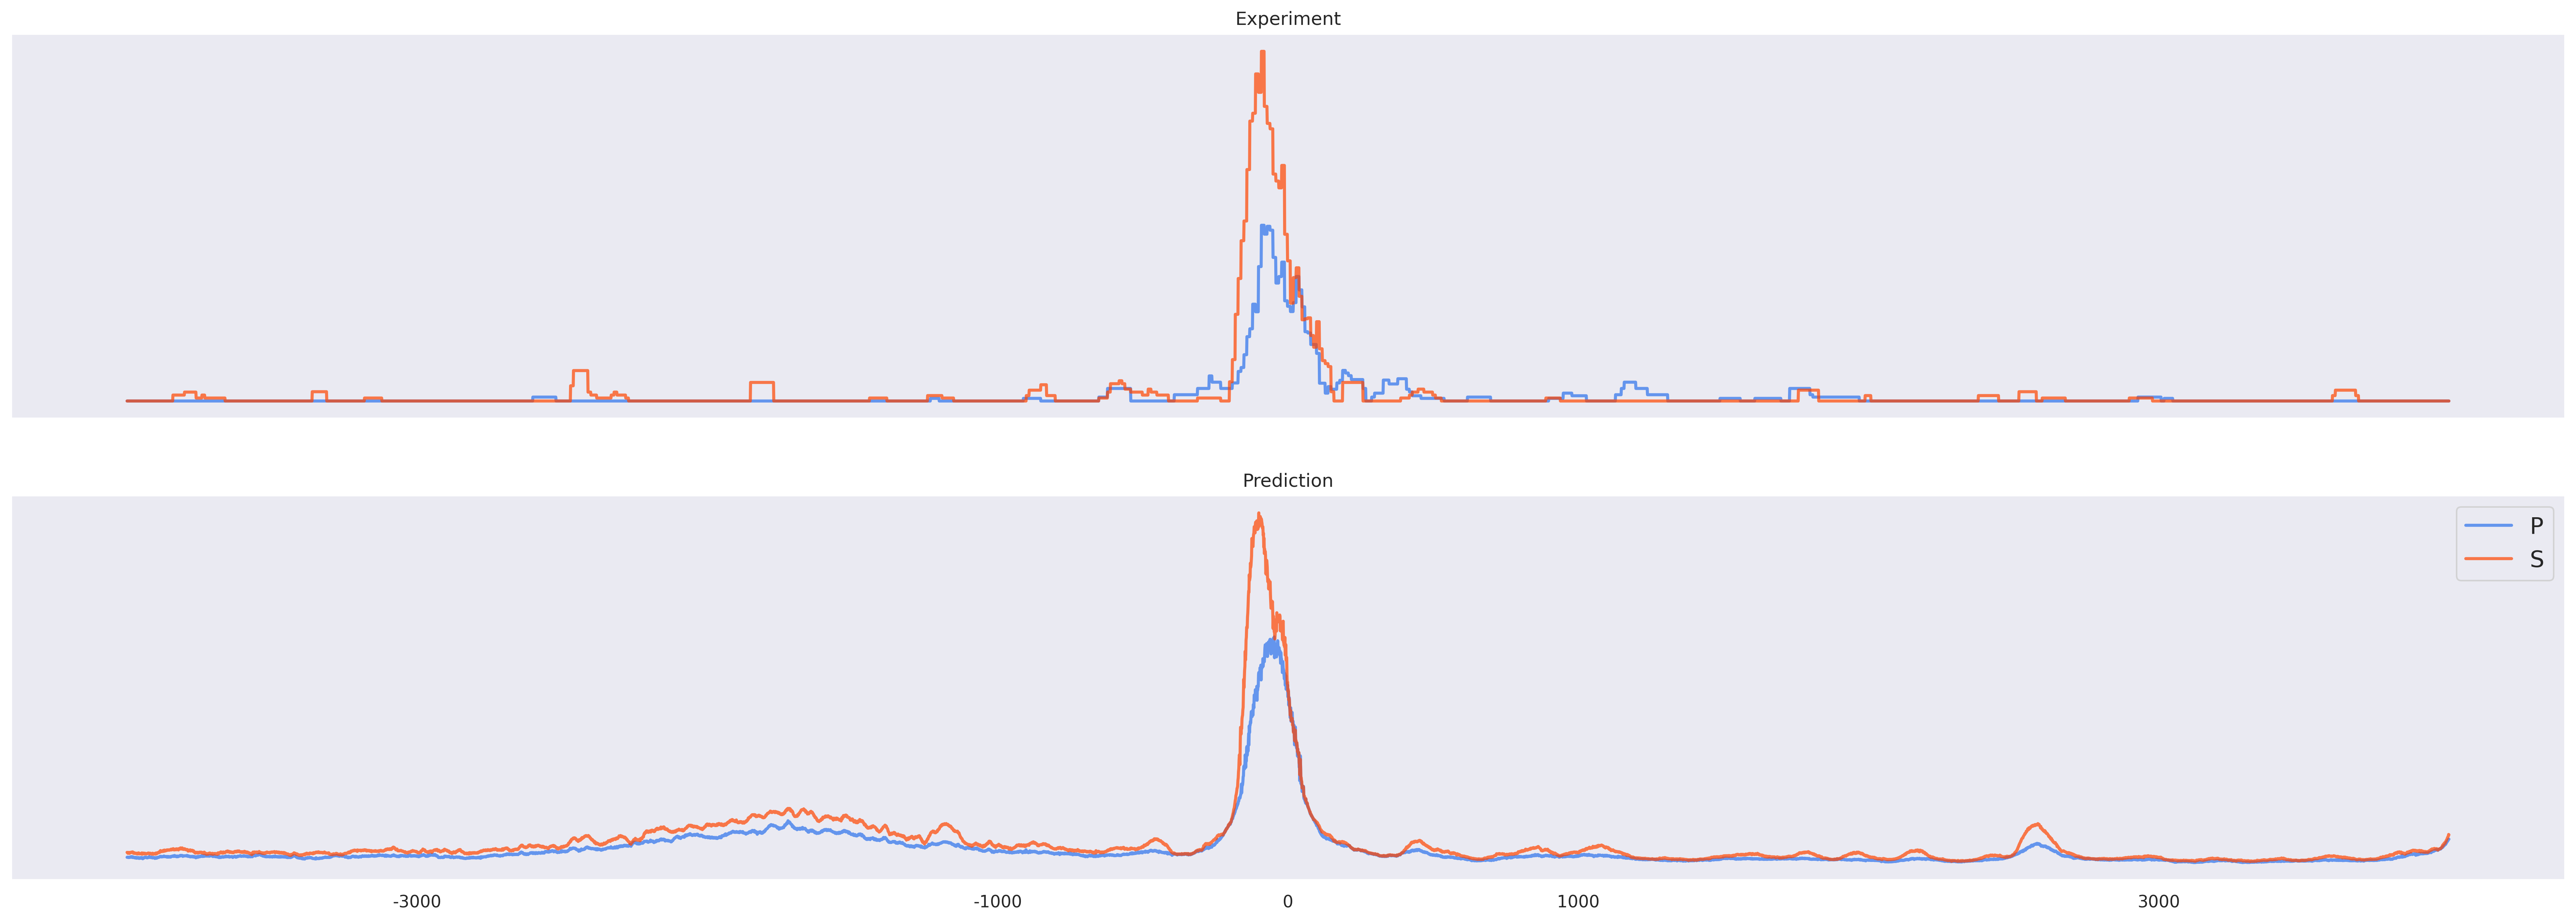

In [27]:

import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,10))


halfwindow=4000
axes[0].plot(range(-halfwindow,halfwindow),allcage[:3,46000:-46000].mean(0).T,linewidth=2,alpha=1,c="#6495ED")
axes[0].plot(range(-halfwindow,halfwindow),allcage[3:,46000:-46000].mean(0).T,linewidth=2,alpha=0.7,c="#FF4500")
axes[0].set_title("Experiment")


axes[1].plot(range(-halfwindow,halfwindow),pred[0,:3,46000:-46000].mean(0),linewidth=2,alpha=1,c="#6495ED",label="P")
axes[1].plot(range(-halfwindow,halfwindow),pred[0,3:,46000:-46000].mean(0),linewidth=2,alpha=0.7,c="#FF4500",label="S")
axes[1].set_title("Prediction")
axes[1].legend(loc='upper right',fontsize=15)


axes[0].grid(False) 
axes[1].grid(False) 

xticks = [-3000,-1000,0,1000,3000]
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xticks)
axes[1].set_yticklabels([])

plt.rcParams['pdf.fonttype'] = 42


In [28]:
ID="Ifi205"
print (ID)
chrm="chr1"
start=174031932
end=174031932


genome = selene_sdk.sequences.Genome(input_path='/work/CRI/s211066/data/mm10/mm10.fa')

seq = genome.get_sequence_from_coords(chrm, end-50000, end+50000)


seq_onehot=torch.FloatTensor(genome.sequence_to_encoding(seq)[None,:,:])
bignet.cuda()
with torch.no_grad():
    puffin_WT = bignet(seq_onehot.transpose(1,2).cuda()).detach().cpu().numpy()
    puffin_WT=puffin_WT[:,3:,:].mean(1)-puffin_WT[:,:3,:].mean(1)
    puffin_WT=puffin_WT[:,50000-600:50000+600].sum(1)
    
print(puffin_WT)

left_add=1000
right_add=1000
ISM_start=50000-left_add
ISM_end=50000+right_add
seq_onehot=seq_onehot.tolist()[0]
puffin_ISM=[]
for i in range(ISM_start,ISM_end):
    # print(i) 
    seq_onehot_i=torch.from_numpy(np.array([seq_onehot[:i]+[[1,0,0,0]]+seq_onehot[(i+1):]],dtype="f")).transpose(1,2).cuda()
    seq_onehot_i=torch.cat((seq_onehot_i,torch.from_numpy(np.array([seq_onehot[:i]+[[0,1,0,0]]+seq_onehot[(i+1):]],dtype="f")).transpose(1,2).cuda()))
    seq_onehot_i=torch.cat((seq_onehot_i,torch.from_numpy(np.array([seq_onehot[:i]+[[0,0,1,0]]+seq_onehot[(i+1):]],dtype="f")).transpose(1,2).cuda()))
    seq_onehot_i=torch.cat((seq_onehot_i,torch.from_numpy(np.array([seq_onehot[:i]+[[0,0,0,1]]+seq_onehot[(i+1):]],dtype="f")).transpose(1,2).cuda()))
    with torch.no_grad():
        # puffin_ISM_i = bignet(seq_onehot_i).detach().cpu().numpy()[:,:,:].mean(1)[:,left_add:left_add+(end-start+1)].sum(1)-puffin_WT
        puffin_ISM_i = bignet(seq_onehot_i).detach().cpu().numpy()
        puffin_ISM_i=puffin_ISM_i[:,3:,:].mean(1)-puffin_ISM_i[:,:3,:].mean(1)
        puffin_ISM_i=puffin_ISM_i[:,50000-600:50000+600].sum(1)-puffin_WT[0]

        puffin_ISM.append(puffin_ISM_i)





Ifi205
[1501.7917]


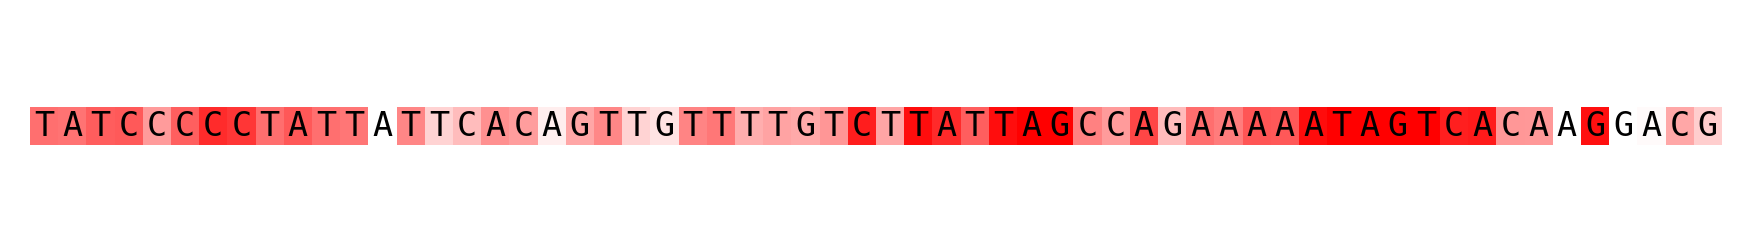

In [30]:
Ism=np.array(-pd.DataFrame(np.array(puffin_ISM)).sum(1))[::-1]
Ism[Ism<0]=0

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

sequence = list(seq[1000-30:1000+30])
fig, ax = plt.subplots(figsize=(len(sequence) * 0.1, 1))

for i, base in enumerate(sequence):

    intensity=Ism[1000-30:1000+30][i]/puffin_WT[0]
    intensity = max(0, min(intensity, 1))


    
    rect = Rectangle((i - 0.5, -0.10), 1, 0.2, color="red", alpha=intensity, linewidth=0)
    ax.add_patch(rect)


    ax.text(i, 0, base, color='black', ha='center', va='center', fontsize=8, fontfamily='monospace')


# Axis cleanup
ax.set_xlim(-0.5, len(sequence) - 0.5)
ax.set_ylim(-0.5, 0.5)
ax.axis('off')  # Remove axis

plt.tight_layout()




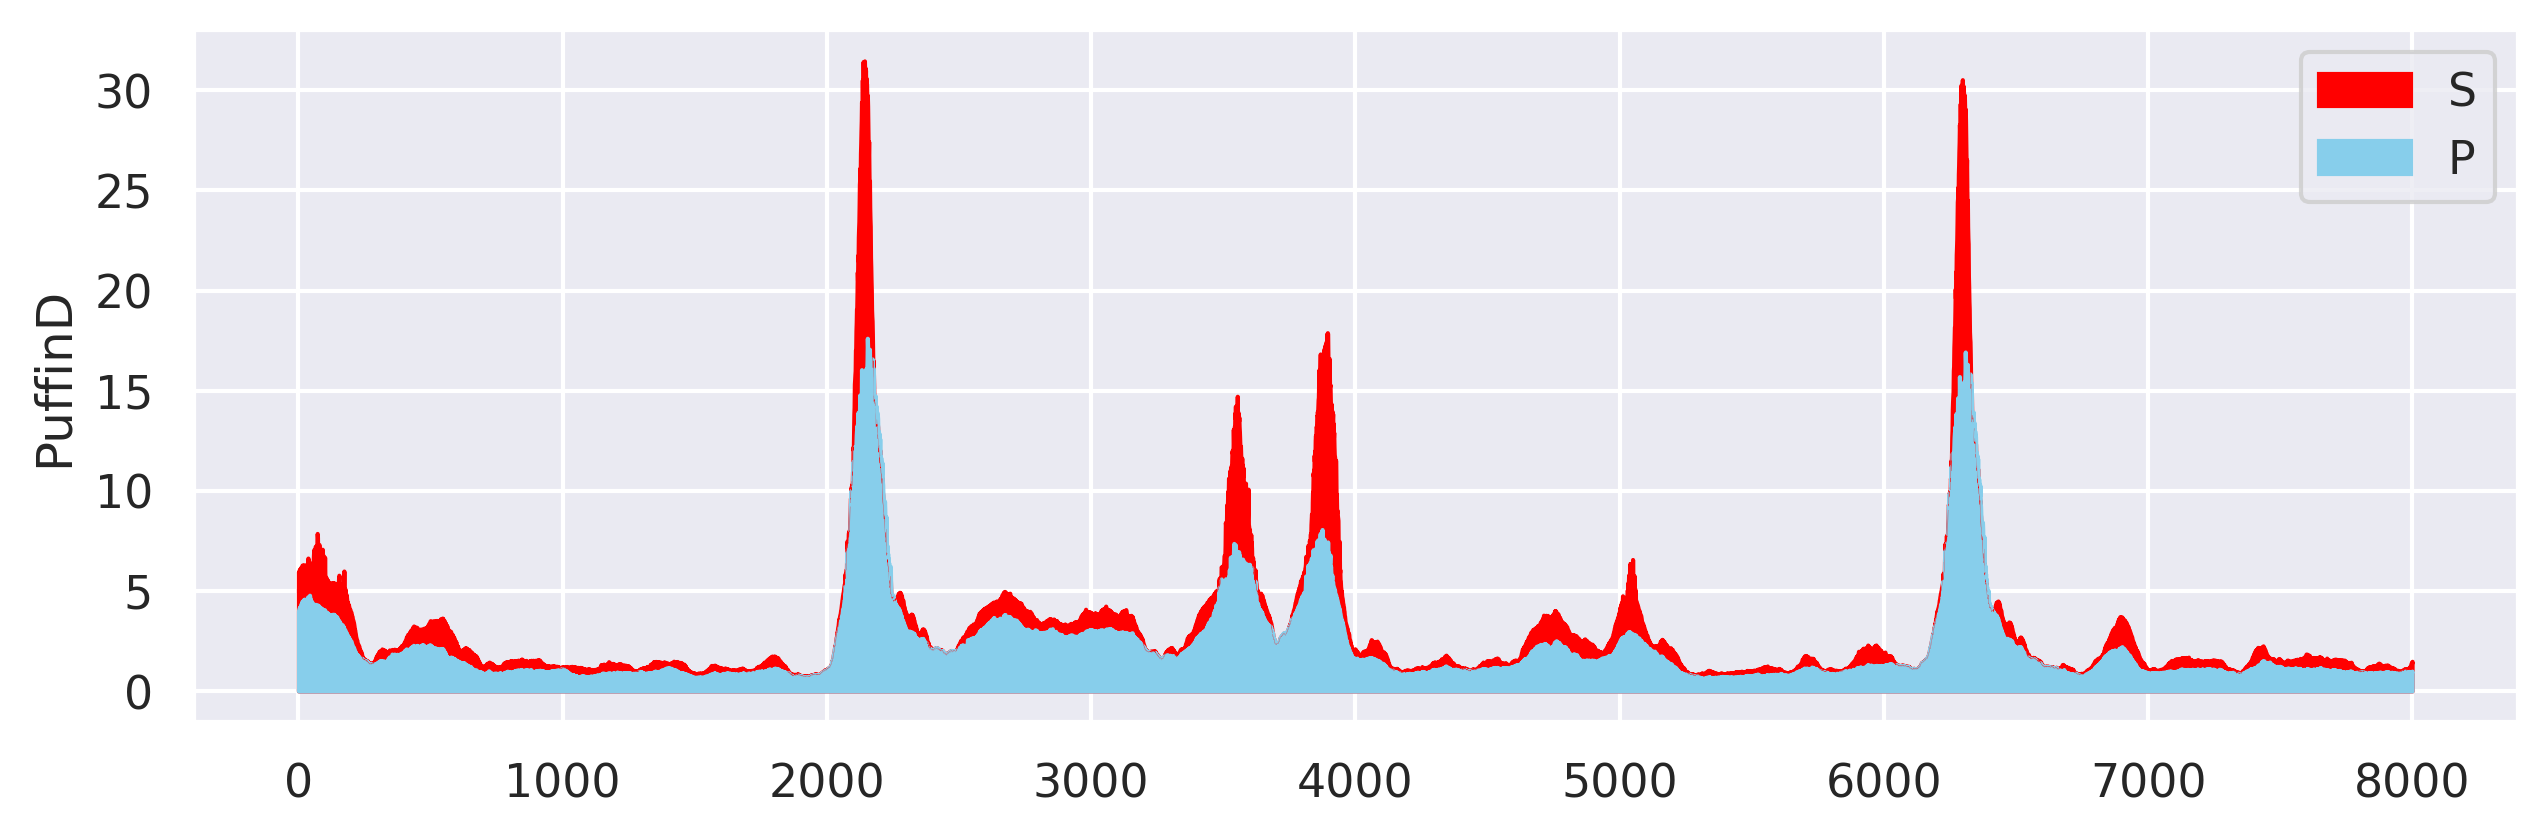

In [31]:

%matplotlib inline 
genome = selene_sdk.sequences.Genome(input_path='/work/CRI/s211066/data/mm10/mm10.fa')
#Puffin-D prediction
chrm="chr11"
pos=86816395

offset=0
strand="-"


seq = genome.get_encoding_from_coords(chrm, pos-50000+offset, pos+50000+offset)


bignet.cuda()
with torch.no_grad():
    pred0 = bignet(torch.FloatTensor(seq.copy())[None,:,:].transpose(1,2).cuda()).detach().cpu().numpy()
pred0=pred0[:,:,::-1]
plt.figure(figsize=(10,3))
plt.plot(pred0[0,3:,50000-2000:50000+6000].mean(0).T, color='red',linewidth=0.1)
plt.fill_between(range(8000),pred0[0,3:,50000-2000:50000+6000].mean(0).T, color='red', alpha=1,label="S")

plt.plot(pred0[0,:3,50000-2000:50000+6000].mean(0).T,color='skyblue',linewidth=0.1)
plt.fill_between(range(8000),pred0[0,:3,50000-2000:50000+6000].mean(0).T, color='skyblue', alpha=1,label="P")
plt.ylabel("PuffinD")
plt.legend()

In [33]:
ID="RLTR6_Mm_dup145"
print (ID)
chrm="chr11"
start=86815876
end=86816395
lenth=end-start+1

genome = selene_sdk.sequences.Genome(input_path='/work/CRI/s211066/data/mm10/mm10.fa')

seq = genome.get_sequence_from_coords(chrm, end-50000, end+50000)


#     return (ID)
seq_onehot=torch.FloatTensor(genome.sequence_to_encoding(seq)[None,:,:])
bignet.cuda()
with torch.no_grad():
    # puffin_WT = bignet(seq_onehot.transpose(1,2).cuda()).detach().cpu().numpy()[0,:,:].mean(0)[left_add:left_add+(end-start+1)].sum()
    puffin_WT = bignet(seq_onehot.transpose(1,2).cuda()).detach().cpu().numpy()
    puffin_WT=puffin_WT[:,3:,:].mean(1)-puffin_WT[:,:3,:].mean(1)
    puffin_WT=puffin_WT[:,50000-600:50000+600].sum(1)
    
print(puffin_WT)

left_add=6000
right_add=2000
ISM_start=50000-left_add
ISM_end=50000+right_add
seq_onehot=seq_onehot.tolist()[0]
puffin_ISM=[]
for i in range(ISM_start,ISM_end):
    # print(i) 
    seq_onehot_i=torch.from_numpy(np.array([seq_onehot[:i]+[[1,0,0,0]]+seq_onehot[(i+1):]],dtype="f")).transpose(1,2).cuda()
    seq_onehot_i=torch.cat((seq_onehot_i,torch.from_numpy(np.array([seq_onehot[:i]+[[0,1,0,0]]+seq_onehot[(i+1):]],dtype="f")).transpose(1,2).cuda()))
    seq_onehot_i=torch.cat((seq_onehot_i,torch.from_numpy(np.array([seq_onehot[:i]+[[0,0,1,0]]+seq_onehot[(i+1):]],dtype="f")).transpose(1,2).cuda()))
    seq_onehot_i=torch.cat((seq_onehot_i,torch.from_numpy(np.array([seq_onehot[:i]+[[0,0,0,1]]+seq_onehot[(i+1):]],dtype="f")).transpose(1,2).cuda()))
    with torch.no_grad():
        # puffin_ISM_i = bignet(seq_onehot_i).detach().cpu().numpy()[:,:,:].mean(1)[:,left_add:left_add+(end-start+1)].sum(1)-puffin_WT
        puffin_ISM_i = bignet(seq_onehot_i).detach().cpu().numpy()
        puffin_ISM_i=puffin_ISM_i[:,3:,:].mean(1)-puffin_ISM_i[:,:3,:].mean(1)
        puffin_ISM_i=puffin_ISM_i[:,50000-600:50000+600].sum(1)-puffin_WT[0]

        puffin_ISM.append(puffin_ISM_i)


RLTR6_Mm_dup145
[1025.5172]


<Axes: >

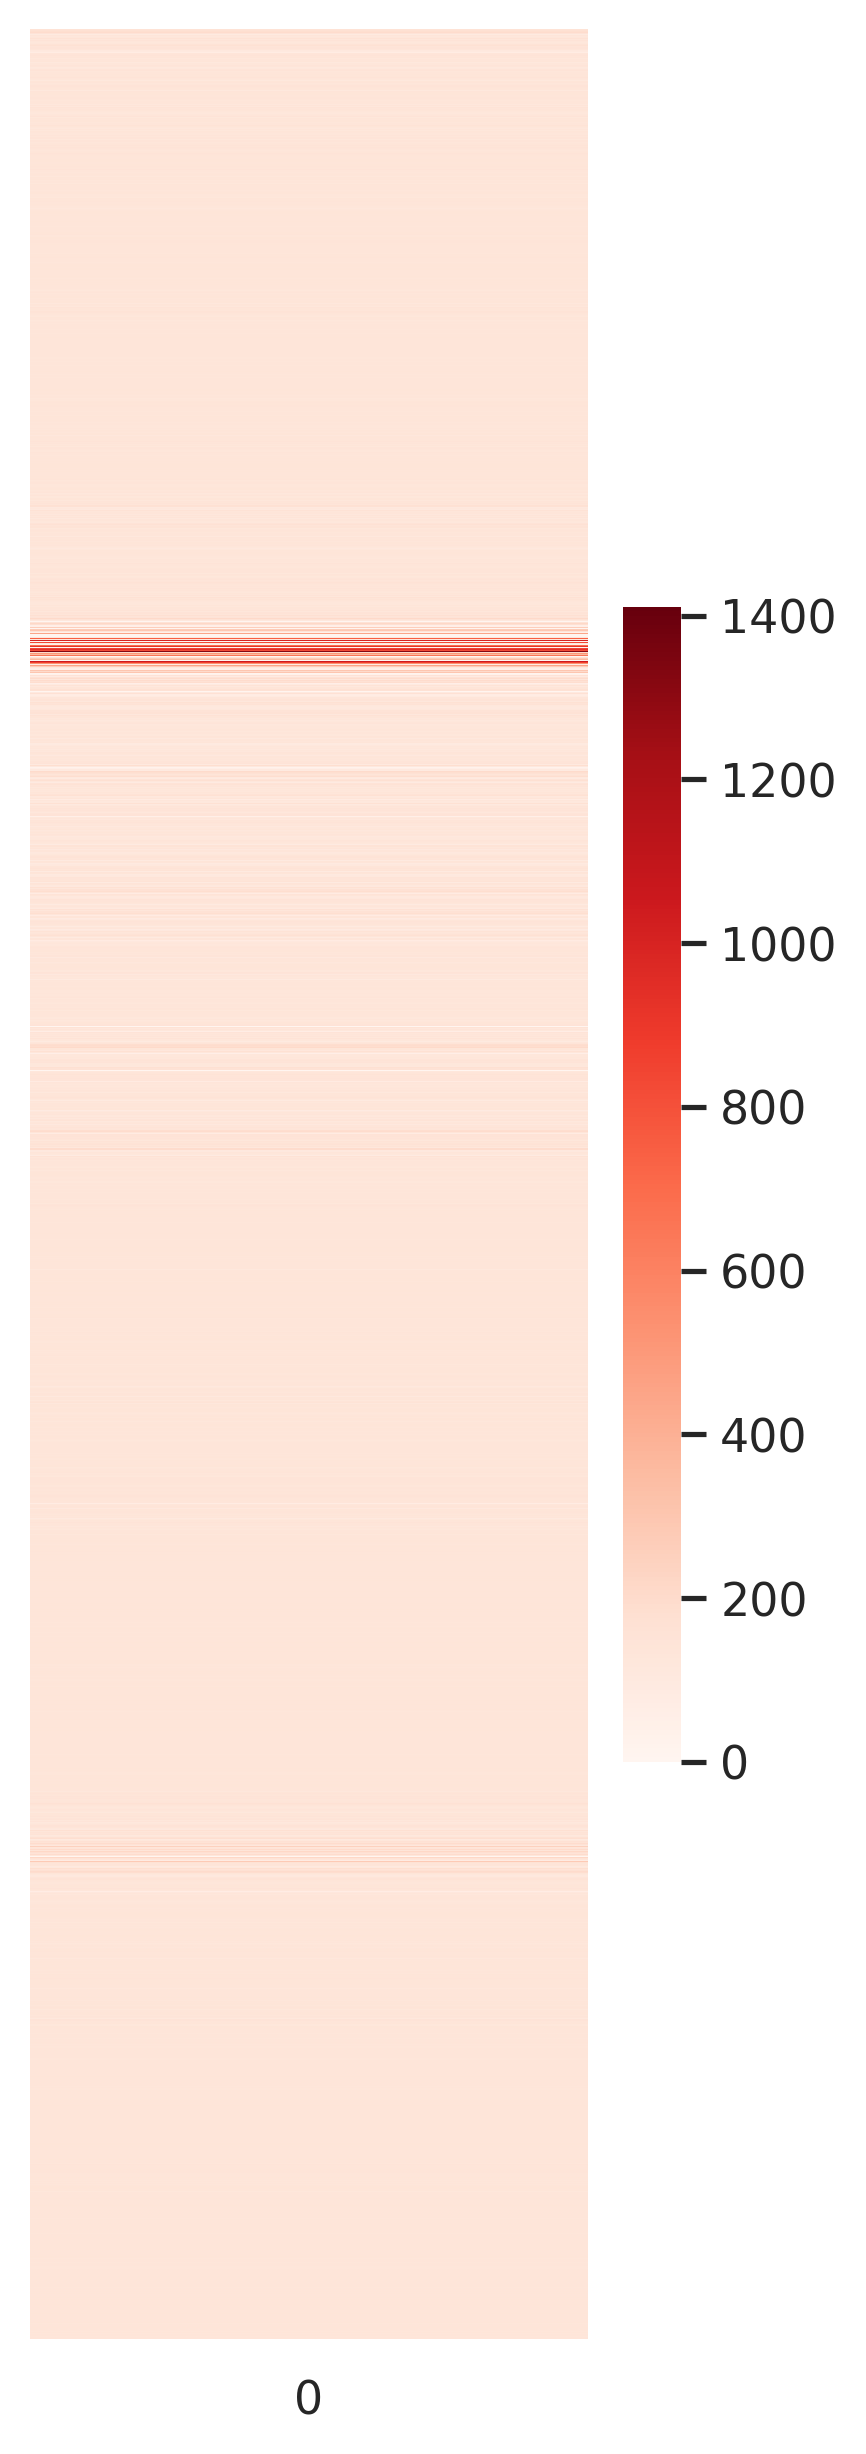

In [35]:
plt.figure(figsize=(3,10))
Ism=np.array(-pd.DataFrame(np.array(puffin_ISM)).sum(1))[::-1]
intensity=Ism/821.3871

sns.heatmap(pd.DataFrame(intensity),vmin=0, cmap="Reds",cbar_kws={'shrink': 0.5}, rasterized=True, xticklabels=True, yticklabels=False)##plt.tight_layout()



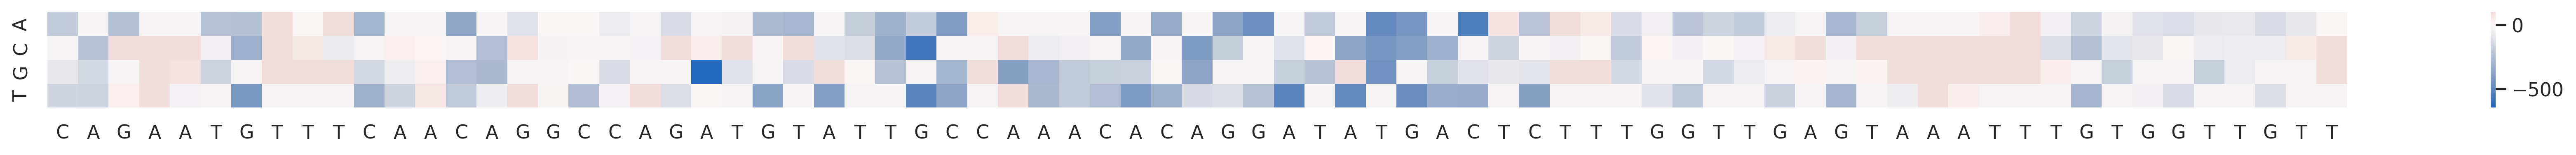

In [37]:

chrm="chr11"
start=86815876
end=86816395
seq = genome.get_sequence_from_coords(chrm, start, end)
seq=genome.sequence_to_encoding(seq)[::-1,::-1]

puffin_ISM_f=pd.DataFrame(np.array(puffin_ISM)[::-1,::-1].T)
puffin_ISM_f.index=["A","C","G","T"]
seq_puffin_ISM_f=np.array(-puffin_ISM_f.iloc[:,2000:2519].sum(0))*seq.T
seq_puffin_ISM_f=pd.DataFrame(seq_puffin_ISM_f)
seq_puffin_ISM_f_S=seq_puffin_ISM_f.iloc[:,110:185]
seq_puffin_ISM_f_S.index=["A","C","G","T"]

chrm="chr11"
start=86815876
end=86816395
seq = genome.get_sequence_from_coords(chrm, start, end)
from Bio.Seq import Seq

dna_seq = Seq(seq)
rev_comp = dna_seq.reverse_complement()
seq=(list(rev_comp)[110:185])
seq=[i.upper() for i in seq]

seq_puffin_ISM_f_S.columns=seq

plt.figure(figsize=(30,1))
puffin_ISM_f[puffin_ISM_f>100]=100
sns.heatmap(puffin_ISM_f.iloc[:,2000+110:2000+185], cmap="vlag",annot_kws={'rotation':90},xticklabels=seq,center=0)
sns.set(font_scale=2)
